# Libraries

In [1]:
# Libraries
import backtrader as bt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import time
import decimal
import os

# Create Strategy

### - Establish datapath

In [2]:
os.chdir('C:\\Users\\asus\\Documents\\Python Projects\\Trading - Research and Backtest\\AAPL')
datapath = os.getcwd() + '\\Databases\\'

In [3]:
files = []
for (dirpath, dirnames, filenames) in os.walk(datapath):
    files.extend(filenames)
    break
files

['AAPL-15min.csv',
 'AAPL-30min.csv',
 'AAPL-5min.csv',
 'AAPL-60min.csv',
 'AAPL-daily.csv']

In [5]:
class OTiOpt(bt.Strategy):
    
    params = (('EMA1', 6),
              ('EMA2', 10),
              ('EMA3', 20),
              ('bband1_std', 1.0),
              ('printlog', False),
              #('adxbot', 20),
              #('adxtop', 30),
              ('adxperiod', 5),
              ('adx_baseline', 15), 
              ('Signal', 0), 
              ('Stoch_dist', 10), 
             )
    
    def log(self, txt, dt = None, h = None, doprint = False):
        '''Logging function for this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            h = h or self.datas[0].datetime.time(0)
            #h = self.datas[0].datetime.hour(0)
            print('%s %s, %s' % (dt.isoformat(), h.isoformat(), txt))     
        
    def __init__(self): 
        # Keep a reference to close price for data[0] in the series
        self.dataclose = self.datas[0].close
        self.dataopen = self.datas[0].open
        self.datavol = self.datas[0].volume
        self.datahigh = self.datas[0].high
        self.datalow = self.datas[0].low
        
        # Keep track of pending order and buy price-commission
        self.order = None
        self.price = None
        self.buycomm = None
        
        # Indicators
        
        ## Background
        self.std = bt.indicators.StdDev(self.dataclose, period = 10, safepow = True)
        
        ## Upper
        self.ema1 = bt.indicators.EMA(self.dataclose, period = self.params.EMA1)
        self.ema2 = bt.indicators.EMA(self.dataclose, period = 10)
        self.ema3 = bt.indicators.EMA(self.dataclose, period = 20)
        self.bband1 = bt.indicators.BollingerBands(self.dataclose, period = 20, devfactor = 2)
        self.delayed_bband_top = self.bband1.lines.top(-1)
        self.delayed_bband_bot = self.bband1.lines.bot(-1)
        self.bband2 = bt.indicators.BollingerBands(self.dataclose, period = 20, devfactor = 3)
        
        ## Lower 1
        self.macd = bt.indicators.MACDHisto(period_me1 = 6, period_me2 = 17, period_signal = 9)
        self.delayed_macd = self.macd.lines.histo(-1)
        self.delayed_macd2 = self.macd.lines.histo(-2)
        
        ## Lower 2
        self.adx = bt.indicators.AverageDirectionalMovementIndex(period = 6)
        sign = self.adx(-1)
        self.sig = self.adx.lines.adx - sign
        
        ## Lower 3
        self.stoch = bt.indicators.Stochastic(period = 8, period_dfast = 2, period_dslow = 2)
        self.delayed_stochK = self.stoch.lines.percK(-1)
        self.delayed_stochD = self.stoch.lines.percD(-1)
        self.cross_stoch = bt.indicators.CrossUp(self.stoch.lines.percK, self.stoch.lines.percD)
        
    def notify_order(self, order):
        # If Buy and/or Sell submitted then accepted by broker - Nothing to do
        if order.status in [order.Submitted, order.Accepted]:
            return
        
        # Check if an order is completed
        if order.status in [order.Completed]:
            
            if order.isbuy():
                self.log('BUY EXECUTED, Price: {:,.2f}'.format(order.executed.price))
            
            elif order.issell():
                self.log('SELL EXECUTED, Price: {:,.2f}'.format(order.executed.price))              
        elif order.status in [order.Cancelled, order.Margin, order.Rejected]:
            self.log('ORDER CANCELLED')
            
        # Write down that there is no order
        self.order = None
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        
        self.log('OPERATION PROFIT/LOSS, GROSS: {:,.2f}'.format(trade.pnl))
    
    def next(self):
        # Log the next price
        self.log('Close: {:,.2f}'.format(self.dataclose[0]), doprint = False)
        
        # If there is a pending order do not order another one
        if self.order:
            return
        
        # Check if we are in the market
        if not self.position:
            # Not in the market
            
            # Buy if
            rules = [((self.dataclose[0] >= self.ema1[0]) or (self.dataopen[0] >= self.ema1[0])), # Price above EMA1
                     ((self.dataclose[0] >= self.ema2[0]) or (self.dataopen[0] >= self.ema2[0])), # Price above EMA2
                     ((self.dataclose[0] >= self.ema3[0]) or (self.dataopen[0] >= self.ema3[0])), # Price above EMA3
                     (self.bband1.lines.top[0] > self.delayed_bband_top[0]), # Higher current top bollinger
                     (self.bband1.lines.bot[0] < self.delayed_bband_bot[0]), # Lower current bottom bollinger
                     (self.macd.lines.histo[0] > self.delayed_macd[0]), # Higher current MACD
                     (self.macd.lines.histo[0] > 0), # MACD above 0
                     (self.adx.lines.adx[0] >= self.params.adx_baseline), # Momentum above 20
                     (self.sig[0] > 0), # Positive momentum
                     (self.cross_stoch.lines.cross == True), # Crossing of StochK and StochD
                     (abs(self.stoch.lines.percK[0] - self.stoch.lines.percD[0]) < self.params.Stoch_dist), # Distance between StochK and StochD
                     (self.stoch.lines.percK[0] >= self.delayed_stochK[0]), # Higher current StochK
                     (self.stoch.lines.percD[0] >= self.delayed_stochD[0]) # Higher current StochD
                    ]
            
            if all(rules):
                self.log('BUY CREATE ORDER: {:,.2f}'.format(self.dataclose[0]))
                self.order = self.buy()
        
        else:
            # Already in the market
            
            # Sell if
            rules1 = [(self.dataclose[0] >= self.bband1.lines.top[0])]
            rules2 = [(self.dataopen[0] >= self.bband1.lines.top[0])]
            rules3 = [(self.datahigh[0] >= self.bband1.lines.top[0])]
            rules4 = [(self.datalow[0] >= self.bband1.lines.top[0])]
            if all(rules1) or all(rules2):
                self.log('SELL CREATE ORDER: {:,.2f}'.format(self.dataclose[0]))
                self.order = self.sell()
                
    def stop(self):
        result['EMA1'].append(self.params.EMA1)
        result['EMA2'].append(self.params.EMA2)
        result['EMA3'].append(self.params.EMA3)
        result['bband1_std'].append(self.params.bband1_std)
        result['adxperiod'].append(self.params.adxperiod)
        result['adx_baseline'].append(self.params.adx_baseline)
        result['Signal'].append(self.params.Signal)
        result['Stoch_dist'].append(self.params.Stoch_dist)
        result['std'].append(self.std.lines.stddev[0])
        result['value'].append(self.broker.getvalue())

In [6]:
class WilliamR(bt.Strategy):
    params = (('target', 0.01),
              ('william_period', 14), ('william_lower', -75), ('william_upper', -25),
              ('bband1_period', 20), ('bband1_stdev', 2), ('bband2_period', 20), ('bband2_stdev', 3),
              ('macd_me1', 6), ('macd_me2', 17), ('macd_sign', 9),
              ('adx_period', 5),
             )
    identity = params
    def log(self, txt, dt = None, h = None, doprint = True):
        '''Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        h = h or self.datas[0].datetime.time(0)
        print('%s %s, %s' % (dt.isoformat(), h.isoformat(), txt))
    def __init__(self):
        if 1:# Keep a reference to prices for data[0] in the series
            self.dataclose = self.datas[0].close
            self.dataopen = self.datas[0].open
            self.datavol = self.datas[0].volume
            self.datahigh = self.datas[0].high
            self.datalow = self.datas[0].low        
        if 1:# Keep track of pending order, buy price-commission, and call-put
            self.order = None
            self.price = None
            self.buycomm = None
            self.call_put = None 
        #----------------------Indicators----------------------#
        if 1: # William %R
            self.williamR = bt.indicators.WilliamsR(period = self.p.william_period, upperband = self.p.william_upper, 
                                                    lowerband = self.p.william_lower)
        if 1: # Support-Resistance
            self.support_resist = bt.indicators.PivotPoint(self.data1, _autoplot = True)
        if 1: # Bollinger Band
            self.bband1 = bt.indicators.BollingerBands(self.dataclose, 
                                                       period = self.p.bband1_period, devfactor = self.p.bband1_stdev)
            self.delayed_bband_top = self.bband1.lines.top(-1)
            self.delayed_bband_bot = self.bband1.lines.bot(-1)
            self.bband2 = bt.indicators.BollingerBands(self.dataclose, 
                                                       period = self.p.bband2_period, devfactor = self.p.bband2_stdev)            
        if 1: # MACD
            self.macd = bt.indicators.MACDHisto(period_me1 = self.p.macd_me1, period_me2 = self.p.macd_me2, period_signal = self.p.macd_sign)
            self.delayed_macd = self.macd.lines.histo(-1)            
        if 1: # ADX
            self.adx = bt.indicators.AverageDirectionalMovementIndex(period = self.p.adx_period)
            self.delayed_adx = self.adx.lines.adx(-1)
            sig = self.adx(-1)
            self.sig = self.adx.lines.adx - sig
    def next(self):
        # Log the next price
        self.log('Close: {:,.2f}'.format(self.dataclose[0]))
        # If there is a pending order, do not order another one
        if self.order:
            return      
        # This is for one position at a time
        # Check if there is a position in the market
        if not self.position: # Not in the market, open position
            def call_if():
                #----------------------William%R----------------------#
                call_rule1 = [self.williamR.lines.percR[0] < self.p.william_lower]
                #----------------------Support-Resistance----------------------#
                call_rule2 = [self.dataclose[0] > self.support_resist.lines.r1]
                #----------------------Bollinger Band----------------------#
                call_rule3 = [(self.bband1.lines.top[0] > self.delayed_bband_top[0]),
                              (self.bband1.lines.bot[0] < self.delayed_bband_bot[0]),
                             ]
                #----------------------MACD----------------------#               
                call_rule4 = [(self.macd.lines.histo[0] > self.delayed_macd[0]),
                              (self.macd.lines.histo[0] > -0.2 and self.macd.lines.histo[0] < 0.2),
                              (abs(self.macd.lines.histo[0]) > 0.1),
                             ]
                #----------------------ADX----------------------#
                call_rule5 = [(self.adx.lines.adx[0] >= 20 and self.adx.lines.adx[0] <= 25),
                             (self.adx.lines.adx[0] > self.delayed_adx[0]),
                            ]
                # Summary
                sum_rules = [call_rule1, call_rule2, call_rule3, call_rule4, call_rule5]
                call_rules = []
                for rules in sum_rules:
                    correct = all(rules)
                    call_rules.append(correct)
                return call_rules
            def put_if():
                #----------------------William%R----------------------#
                put_rule1 = [self.williamR.lines.percR[0] > self.p.william_upper]
                #----------------------Suppport-Resistance----------------------#
                put_rule2 = [self.dataclose[0] < self.support_resist.lines.s1]
                #----------------------Bollinger Band----------------------#
                put_rule3 = [(self.bband1.lines.top[0] > self.delayed_bband_top[0]),
                             (self.bband1.lines.bot[0] < self.delayed_bband_bot[0]),
                            ]
                #----------------------MACD----------------------#
                put_rule4 = [(self.macd.lines.histo[0] < self.delayed_macd[0]),
                             (self.macd.lines.histo[0] > -0.2),
                             (abs(self.macd.lines.histo[0]) > 0.1),
                            ]
                #----------------------ADX----------------------#
                put_rule5 = [(self.adx.lines.adx[0] >= 20 and self.adx.lines.adx[0] <= 25),
                             (self.adx.lines.adx[0] > self.delayed_adx[0]),
                            ]
                # Summary
                sum_rules = [put_rule1, put_rule2, put_rule3, put_rule4, put_rule5]
                put_rules = []
                for rules in sum_rules:
                    correct = all(rules)
                    put_rules.append(correct)
                return put_rules
            if all(call_if()): 
                self.log('BUY CALL CREATE ORDER: {:,.2f}'.format(self.dataclose[0]))
                self.order = self.buy()
                self.call_put = 'buy call'
            elif all(put_if()):
                self.log('BUY PUT CREATE ORDER: {:,.2f}'.format(self.dataclose[0]))
                self.order = self.sell()
                self.call_put = 'buy put'            
        else: # Close position
            #if self.datas[0].datetime.time(0) < datetime.time(15, 30): # time
            target_achieved_call = [((self.target_p <= self.dataclose[0]) or (self.target_p <= self.dataopen[0])) or
                                    ((self.target_l >= self.dataclose[0]) or (self.target_l >= self.dataopen[0]))]
            target_achieved_put = [((self.target_p >= self.dataclose[0]) or (self.target_p >= self.dataopen[0])) or
                                   ((self.target_l <= self.dataclose[0]) or (self.target_l <= self.dataopen[0]))]
            if  all(target_achieved_call) and self.call_put == 'buy call':
                self.log('SELL CALL CREATE ORDER: {:,.2f}'.format(self.dataclose[0]))
                self.order = self.sell()
                self.call_put = 'sell call'
            elif all(target_achieved_put) and self.call_put == 'buy put':
                self.log('SELL PUT CREATE ORDER: {:,.2f}'.format(self.dataclose[0]))
                self.order = self.buy()
                self.call_put = 'sell put'        
    def notify_order(self, order):
        # If Buy and/or Sell submitted then accepted by broker - Nothing to do
        if order.status in [order.Submitted, order.Accepted]:
            return
        #Check if an order is completed
        if order.status in [order.Completed]:
            if self.call_put == 'buy call' and order.isbuy():
                self.log('BUY CALL EXECUTED, Price: {:,.2f}'.format(order.executed.price))
                self.target_p = order.executed.price * (1+self.p.target)
                self.target_l = order.executed.price * (1-self.p.target*10)
            elif self.call_put == 'sell call' and order.issell():
                self.log('SELL CALL EXECUTED, Price: {:,.2f}'.format(order.executed.price))
            elif self.call_put == 'buy put' and order.issell():
                self.log('BUY PUT EXECUTED, Price: {:,.2f}'.format(order.executed.price))
                self.target_p = order.executed.price * (1-self.p.target)
                self.target_l = order.executed.price * (1+self.p.target)
            elif self.call_put == 'sell put' and order.isbuy():
                self.log('SELL PUT EXECUTED, Price: {:,.2f}'.format(order.executed.price))
        elif order.status in [order.Cancelled, order.Margin, order.Rejected]:
            self.log('ORDER CANCELLED')
        # Write down that there is no order
        self.order = None
        return self.target_p, self.target_l
    def notify_trade(self, trade):
        if not trade.isclosed:
            return        
        self.log('OPERATION PROFIT/LOSS, GROSS: {:,.2f}'.format(trade.pnl))

# Brokerage Account

In [170]:
# Optimization of OTi Strategy
result = {'EMA1' : [], 'EMA2' : [], 'EMA3' : [], 'bband1_std' : [], 'adxperiod' : [],
          'adx_baseline' : [], 'Signal' : [], 'Stoch_dist' : [], 'std' : [], 'value': []}
time = '5min'
if __name__ == '__main__':
    
    # Parameters
    params = {'setcash' : 1000, 
              'commission': 0,
              'stake' : 1,
              'dataname' : datapath + [s for s in files if '-'+time in s][0],
             }
    
    # Create brokerage entity
    cerebro = bt.Cerebro()
    
    # Optimize Strategy
    def float_range(start, stop, step): # For float range
      while start < stop:
        yield float(start)
        start += decimal.Decimal(step)
        
    cerebro.optstrategy(WilliamR,
                        #EMA1 = range(6, 10),
                        #EMA2 = range(10, 20),
                        #EMA3 = range(20, 31),
                        bband1_std = float_range(1, 3, 0.2),
                        #adxperiod = range(6, 9),
                        adx_baseline = range(10, 31),
                        #Signal = range(-5, 6),
                        #Stoch_dist = [10, 28, 29, 30]
                       )
    
    # Create datafeed
    datafeed = bt.feeds.GenericCSVData(dataname = params['dataname'],
                                       timeframe = bt.TimeFrame.Minutes,
                                       compression = 5,
                                       #sessionstart = datetime.time(9, 35),
                                       #sessionend = datetime.time(16, 0),
                                       reverse = False, datetime = 0, time = 6,
                                       high = 2, low = 3, open = 1, close = 4, volume = 5, openinterest = -1,
                                       nullvalue = 0.0, #fromdate = datetime.datetime(2020, 4, 15), todate = datetime.datetime(2020, 4, 16),
                                       dtformat = ('%Y-%m-%d'), tmformat = ('%H:%M:%S')
                                      ) # 
    
    # Add datafeed to cerebro
    cerebro.adddata(datafeed)
    cerebro.resampledata(datafeed, timeframe=bt.TimeFrame.Minutes, compression = 5*50)
    
    # Set desired cash
    cerebro.broker.setcash(params['setcash'])
    
    # Add a fixed stake (how many stocks to buy)
    cerebro.addsizer(bt.sizers.FixedSize, stake = params['stake'])
    
    # Set comission
    cerebro.broker.setcommission(commission = params['commission'])
    
    # Run over everything
    cerebro.run(maxcpus = 1)

In [171]:
df_result_opt = pd.DataFrame(result)
df_result_opt.sort_values(by = ['value'], ascending = False)

EMA1  EMA2  EMA3  bband1_std  adxperiod  adx_baseline  Signal  \
61      6    10    20         1.4          5            29       0   
145     6    10    20         2.2          5            29       0   
19      6    10    20         1.0          5            29       0   
187     6    10    20         2.6          5            29       0   
82      6    10    20         1.6          5            29       0   
..    ...   ...   ...         ...        ...           ...     ...   
75      6    10    20         1.6          5            22       0   
76      6    10    20         1.6          5            23       0   
77      6    10    20         1.6          5            24       0   
78      6    10    20         1.6          5            25       0   
105     6    10    20         2.0          5            10       0   

     Stoch_dist       std      value  
61           10  0.403224  1014.3575  
145          10  0.403224  1014.3575  
19           10  0.403224  1014.3575  
187          10  0.403224  1014.3575  
82           10  0.403224  1014.3575  
..          ...       ...        ...  
75           10  0.403224  1012.2292  
76           10  0.403224  1012.2292  
77           10  0.403224  1012.2292  
78           10  0.403224  1012.2292  
105          10  0.403224  1012.2292  

[210 rows x 10 columns]

In [91]:
df_result_opt[(df_result_opt['value'] >= 1001.3150) & (df_result_opt['std'] >= 0.188326)]

EMA1  EMA2  EMA3  bband1_std  adxperiod  adx_baseline  Signal  \
0       6    10    20         2.0          6            24       0   
1       6    10    20         2.0          6            24       0   
2       6    10    20         2.0          6            24       0   
3       6    10    20         2.0          6            24       0   
16      6    10    20         2.0          7            24       0   
17      6    10    20         2.0          7            24       0   
18      6    10    20         2.0          7            24       0   
19      6    10    20         2.0          7            24       0   
32      6    10    20         2.0          8            24       0   
33      6    10    20         2.0          8            24       0   
34      6    10    20         2.0          8            24       0   
35      6    10    20         2.0          8            24       0   
48      6    10    20         2.2          6            24       0   
49      6    10    20         2.2          6            24       0   
50      6    10    20         2.2          6            24       0   
51      6    10    20         2.2          6            24       0   
64      6    10    20         2.2          7            24       0   
65      6    10    20         2.2          7            24       0   
66      6    10    20         2.2          7            24       0   
67      6    10    20         2.2          7            24       0   
80      6    10    20         2.2          8            24       0   
81      6    10    20         2.2          8            24       0   
82      6    10    20         2.2          8            24       0   
83      6    10    20         2.2          8            24       0   
96      6    10    20         2.4          6            24       0   
97      6    10    20         2.4          6            24       0   
98      6    10    20         2.4          6            24       0   
99      6    10    20         2.4          6            24       0   
112     6    10    20         2.4          7            24       0   
113     6    10    20         2.4          7            24       0   
114     6    10    20         2.4          7            24       0   
115     6    10    20         2.4          7            24       0   
128     6    10    20         2.4          8            24       0   
129     6    10    20         2.4          8            24       0   
130     6    10    20         2.4          8            24       0   
131     6    10    20         2.4          8            24       0   
144     6    10    20         2.6          6            24       0   
145     6    10    20         2.6          6            24       0   
146     6    10    20         2.6          6            24       0   
147     6    10    20         2.6          6            24       0   
160     6    10    20         2.6          7            24       0   
161     6    10    20         2.6          7            24       0   
162     6    10    20         2.6          7            24       0   
163     6    10    20         2.6          7            24       0   
176     6    10    20         2.6          8            24       0   
177     6    10    20         2.6          8            24       0   
178     6    10    20         2.6          8            24       0   
179     6    10    20         2.6          8            24       0   

     Stoch_dist       std      value  
0            10  0.188327  1001.3151  
1            28  0.188327  1001.3151  
2            29  0.188327  1001.3151  
3            30  0.188327  1001.3151  
16           10  0.188327  1001.3151  
17           28  0.188327  1001.3151  
18           29  0.188327  1001.3151  
19           30  0.188327  1001.3151  
32           10  0.188327  1001.3151  
33           28  0.188327  1001.3151  
34           29  0.188327  1001.3151  
35           30  0.188327  1001.3151  
48           10  0.188327  1001.3151  
49           28  0.188327  1

In [81]:
df_result_opt['Stoch_dist'][df_result_opt['std'] >= 0.188326]

0      10
1      28
2      29
3      30
4      10
       ..
187    30
188    10
189    28
190    29
191    30
Name: Stoch_dist, Length: 192, dtype: int64

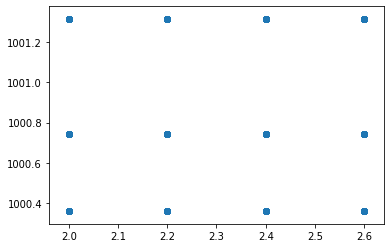

In [103]:
%matplotlib inline
plt.scatter(x = 'bband1_std', y = 'value', data = df_result_opt)

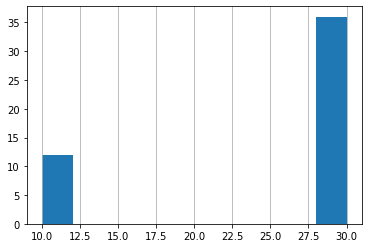

In [92]:
%matplotlib  inline
plt.hist(df_result_opt['Stoch_dist'][(df_result_opt['value'] >= 1001.3150) & (df_result_opt['std'] >= 0.188326)])
#plt.xticks(range(5, 31))
plt.grid(axis = 'x')

In [165]:
df_result_opt.corr()

EMA1  EMA2  EMA3    bband1_std  adxperiod  adx_baseline  Signal  \
EMA1           NaN   NaN   NaN           NaN        NaN           NaN     NaN   
EMA2           NaN   NaN   NaN           NaN        NaN           NaN     NaN   
EMA3           NaN   NaN   NaN           NaN        NaN           NaN     NaN   
bband1_std     NaN   NaN   NaN  1.000000e+00        NaN -1.952272e-17     NaN   
adxperiod      NaN   NaN   NaN           NaN        NaN           NaN     NaN   
adx_baseline   NaN   NaN   NaN -1.952272e-17        NaN  1.000000e+00     NaN   
Signal         NaN   NaN   NaN           NaN        NaN           NaN     NaN   
Stoch_dist     NaN   NaN   NaN           NaN        NaN           NaN     NaN   
std            NaN   NaN   NaN -3.163458e-15        NaN  0.000000e+00     NaN   
value          NaN   NaN   NaN  5.930437e-17        NaN  4.983238e-01     NaN   

              Stoch_dist           std         value  
EMA1                 NaN           NaN           NaN  
EMA2                 NaN           NaN           NaN  
EMA3                 NaN           NaN           NaN  
bband1_std           NaN -3.163458e-15  5.930437e-17  
adxperiod            NaN           NaN           NaN  
adx_baseline         NaN  0.000000e+00  4.983238e-01  
Signal               NaN           NaN           NaN  
Stoch_dist           NaN           NaN           NaN  
std                  NaN  1.000000e+00 -1.471483e-12  
value                NaN -1.471483e-12  1.000000e+00

In [154]:
round(-1.471483e-12, ndigits = 11)

-0.0

In [147]:
4.983238e-01

0.4983238